In [1]:
import pennylane as qml # To define the circuit
from pprop.propagator import Propagator # For Pauli Propagation
import numpy as np
from itertools import combinations

$
\displaystyle
\text{IQP Ansatz:} \qquad \langle \hat{Z}_a \rangle = \frac1s \sum_i \cos\left(\sum_j \theta_j (-1)^{g_j\cdot z_i} (1 - (-1)^{g_j\cdot a})\right)
$

* $\{z_i\}$ is set of $s$ bit strings sampled from the Uniform distribution $\mathcal{U}$
* $a$ is the operator index (e.g. $\langle Z_1\rangle := (1,0,0,\cdots,0)$)
* $j$ iterates over every gate
* $g_j$ represents the involved qubits for the $j$-th gate

In [2]:
def iqp_ansatz_builder(n_qubits: int, max_weight=2):
    gates = []
    for weight in np.arange(1, max_weight+1):
        for gate in combinations(np.arange(n_qubits), weight):
            gates.append([list(gate)])

    def iqp_ansatz(params : list[float]):
        for i in range(n_qubits):
            qml.Hadamard(i)

        for par, gate in zip(params, gates):
            for gen in gate:
                qml.MultiRZ.compute_decomposition(2*par, wires=gen)

        for i in range(n_qubits):
            qml.Hadamard(i)
            
        # return [qml.expval(qml.PauliZ(qubit)) for qubit in range(n_qubits)] + [qml.expval(qml.PauliZ(qubit)@qml.PauliZ(qubit+1)) for qubit in range(n_qubits-1)] 
        return [qml.expval(qml.PauliZ(qubit)@qml.PauliZ(qubit+1)) for qubit in range(n_qubits-1)] 

        
    return iqp_ansatz

def semiiqp_ansatz_builder(n_qubits: int, max_weight=2):
    gates = []
    for weight in np.arange(1, max_weight+1):
        for gate in combinations(np.arange(n_qubits), weight):
            gates.append([list(gate)])

    def iqp_ansatz(params : list[float]):
        for i in range(n_qubits):
            qml.RY(params[i], i)

        for i in range(n_qubits):
            qml.Hadamard(i)

        for par, gate in zip(params[n_qubits:], gates):
            for gen in gate:
                qml.MultiRZ.compute_decomposition(2*par, wires=gen)

        for i in range(n_qubits):
            qml.Hadamard(i)
            
        return [qml.expval(qml.PauliZ(qubit)) for qubit in range(n_qubits)] + [qml.expval(qml.PauliX(qubit)@qml.PauliX(qubit+1)) for qubit in range(n_qubits-1)] 

        
    return iqp_ansatz

In [3]:
prop = Propagator(
    iqp_ansatz_builder(n_qubits=6, max_weight=2), 
    k1 = None, # Cutoff on the Pauli Weight
    k2 = None, # Cutoff on the frequencies
)
prop

Propagator
  Number of qubits : 6
  Trainable parameters : 21
  Cutoff 1: None | Cutoff 2: None
  Observables [(Z(0) @ Z(1)), (Z(1) @ Z(2)), (Z(2) @ Z(3)), (Z(3) @ Z(4)), (Z(4) @ Z(5))]
0: ──H──RZ─╭X──RZ─╭X─╭X──RZ─╭X─╭X──RZ─╭X─╭X──RZ─╭X─╭X──RZ─╭X──H────────────────────────────── ···
1: ──H──RZ─╰●─────╰●─│──────│──│──────│──│──────│──│──────│──╭X──RZ─╭X─╭X──RZ─╭X─╭X──RZ─╭X─╭X ···
2: ──H──RZ───────────╰●─────╰●─│──────│──│──────│──│──────│──╰●─────╰●─│──────│──│──────│──│─ ···
3: ──H──RZ─────────────────────╰●─────╰●─│──────│──│──────│────────────╰●─────╰●─│──────│──│─ ···
4: ──H──RZ───────────────────────────────╰●─────╰●─│──────│──────────────────────╰●─────╰●─│─ ···
5: ──H──RZ─────────────────────────────────────────╰●─────╰●───────────────────────────────╰● ···

0: ··· ───────────────────────────────────────────────────────────────────────┤ ╭<Z@Z>        ···
1: ··· ──RZ─╭X──H─────────────────────────────────────────────────────────────┤ ╰<Z@Z> ╭<Z@Z> ···
2: ··· ─────│──╭X──RZ─╭X─╭X──

In [4]:
p_dict = prop.propagate()

Propagating (Z(4) @ Z(5)): 100%|██████████| 5/5 [00:00<00:00, 31.38it/s]


In [5]:
prop.hist

array([2, 2, 2, ..., 6, 6, 6], shape=(5120,))

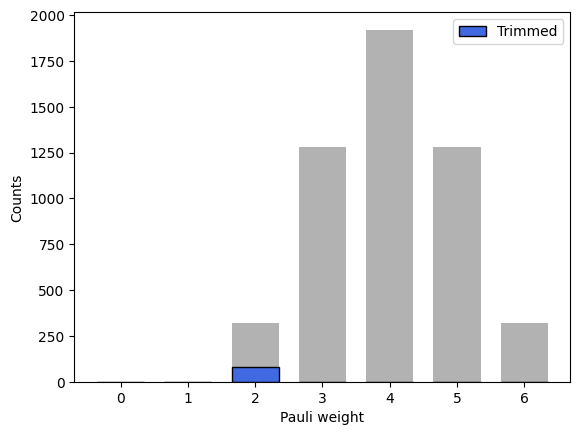

In [6]:
from pprop.plot.obs import plot_obs
plot_obs(prop)

In [7]:
prop.expression()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

['Z0@Z1 = sin(\\theta_{0})*sin(\\theta_{10})*sin(\\theta_{11})*sin(\\theta_{12})*sin(\\theta_{14})*sin(\\theta_{1})*sin(\\theta_{7})*sin(\\theta_{8})*cos(\\theta_{13})*cos(\\theta_{9}) + sin(\\theta_{0})*sin(\\theta_{10})*sin(\\theta_{11})*sin(\\theta_{13})*sin(\\theta_{14})*sin(\\theta_{1})*sin(\\theta_{7})*sin(\\theta_{9})*cos(\\theta_{12})*cos(\\theta_{8}) + sin(\\theta_{0})*sin(\\theta_{10})*sin(\\theta_{12})*sin(\\theta_{13})*sin(\\theta_{14})*sin(\\theta_{1})*sin(\\theta_{8})*sin(\\theta_{9})*cos(\\theta_{11})*cos(\\theta_{7}) + sin(\\theta_{0})*sin(\\theta_{10})*sin(\\theta_{14})*sin(\\theta_{1})*cos(\\theta_{11})*cos(\\theta_{12})*cos(\\theta_{13})*cos(\\theta_{7})*cos(\\theta_{8})*cos(\\theta_{9}) + sin(\\theta_{0})*sin(\\theta_{11})*sin(\\theta_{12})*sin(\\theta_{13})*sin(\\theta_{1})*sin(\\theta_{7})*sin(\\theta_{8})*sin(\\theta_{9})*cos(\\theta_{10})*cos(\\theta_{14}) + sin(\\theta_{0})*sin(\\theta_{11})*sin(\\theta_{1})*sin(\\theta_{7})*cos(\\theta_{10})*cos(\\theta_{12})*